# Topic: Kaggle Campaign - Game of Thrones 
Description: Using decision tree to predict the characters in the game of thrones will die or survive.
Please refer to the dataset: https://www.kaggle.com/mylesoneill/game-of-thrones

## Step1: Import the needed tools and datasets
Firstly, import all tools and dataset which are needed, including the the tools for manage dataframe, array, and the tools for drawing the diagram. Also, importing the model constructing tools from scikit-learn, and the confusion matrix for showing the accuacy rate. As the data showed, there are 12 columns in total, among them, the columns of "Death Year", "Book of Death" and "Death Chapter" represents the inormation of the character die or survie. Therefore, we see three column as one feature.

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
#load data
df = pd.read_csv("character-deaths.csv")
df.head(3)

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1


## Step2: Data Pre-processing 

Firstly, checking the missing value and fulfill the appropriate value. Secondly, since the "Allegiances" is categorical variable, therefore it should be transform into dummy features. After finishing all the data organization, we can split X and Y, train and test data.

In [3]:
#check missing value 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 13 columns):
Name                  917 non-null object
Allegiances           917 non-null object
Death Year            305 non-null float64
Book of Death         307 non-null float64
Death Chapter         299 non-null float64
Book Intro Chapter    905 non-null float64
Gender                917 non-null int64
Nobility              917 non-null int64
GoT                   917 non-null int64
CoK                   917 non-null int64
SoS                   917 non-null int64
FfC                   917 non-null int64
DwD                   917 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 93.3+ KB


In [4]:
#fill in "Death Year" missing value with 0
df = df.rename(columns = {'Death Year':'Death'})
df['Death'] = df.Death.fillna(0)
#fill in 1 replace origin number
df.Death[df.Death>0] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
#fill in "Book Intro Chapter" missing value with 0
df = df.rename(columns = {'Book Intro Chapter':'Intro'})
df['Intro'] = df.Intro.fillna(0)
#df.Intro[df.Intro>0] = 1

In [6]:
#make allegiances turn into dummy features
df1 = pd.get_dummies(df.Allegiances)

In [7]:
#organize data
df = pd.concat([df, df1], axis = 1)
df = df.drop(['Allegiances', 'Book of Death', 'Death Chapter'], axis = 1)

In [8]:
df

,Name,Death,Intro,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,...,House Tyrell,Lannister,Martell,Night's Watch,None,Stark,Targaryen,Tully,Tyrell,Wildling
0,Addam Marbrand,0.0,56.0,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,Aegon Frey (Jinglebell),1.0,49.0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Aegon Targaryen,0.0,5.0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Adrack Humble,1.0,20.0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Aemon Costayne,0.0,0.0,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,Zollo,0.0,21.0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
913,Yurkhaz zo Yunzak,1.0,47.0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
914,Yezzan Zo Qaggaz,1.0,25.0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
915,Torwynd the Tame,1.0,73.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
#split train and test data
from sklearn.model_selection import train_test_split
x = df.iloc[:, 2:]
y = df.loc[:, 'Death']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

## Step3: Select Important Features
Before train the model, we can select some important features among all the features. We sort all the features first, then select feature by threshold.

In [10]:
#Make an instance of the Model
clf = DecisionTreeClassifier().fit(x_train, y_train)

In [11]:
#get importance
importance = clf.feature_importances_
#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.37219
Feature: 1, Score: 0.02940
Feature: 2, Score: 0.06963
Feature: 3, Score: 0.02869
Feature: 4, Score: 0.06071
Feature: 5, Score: 0.06356
Feature: 6, Score: 0.09711
Feature: 7, Score: 0.05916
Feature: 8, Score: 0.01202
Feature: 9, Score: 0.01330
Feature: 10, Score: 0.00720
Feature: 11, Score: 0.00227
Feature: 12, Score: 0.00975
Feature: 13, Score: 0.02266
Feature: 14, Score: 0.01013
Feature: 15, Score: 0.00735
Feature: 16, Score: 0.00448
Feature: 17, Score: 0.00349
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00092
Feature: 20, Score: 0.02061
Feature: 21, Score: 0.00107
Feature: 22, Score: 0.02274
Feature: 23, Score: 0.03343
Feature: 24, Score: 0.02363
Feature: 25, Score: 0.00462
Feature: 26, Score: 0.00391
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.01598


<AxesSubplot:xlabel='feature'>

<Figure size 3600x3600 with 0 Axes>

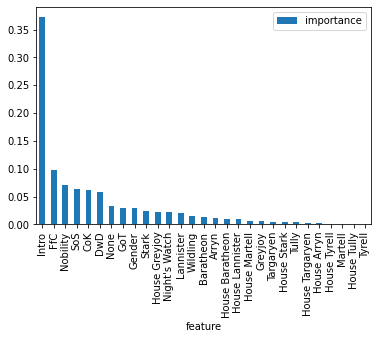

In [12]:
#sort feature importance
plt.figure(figsize=(50, 50))
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(clf.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature')  
importances.plot.bar()

In [13]:
#select feature by threshold
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, estimator = 'feature_importances_', threshold = 0.05, prefit=True)
feature_idx = model.get_support()
feature_names = x.columns[feature_idx]
x = model.transform(x)
x = pd.DataFrame(x, columns= feature_names)

## Step4: Construct Model

In [32]:
#re-split dataset
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)
clf = DecisionTreeClassifier(max_depth = 8).fit(x_train, y_train)

In [33]:
clf.score(x_test,y_test)

0.691304347826087

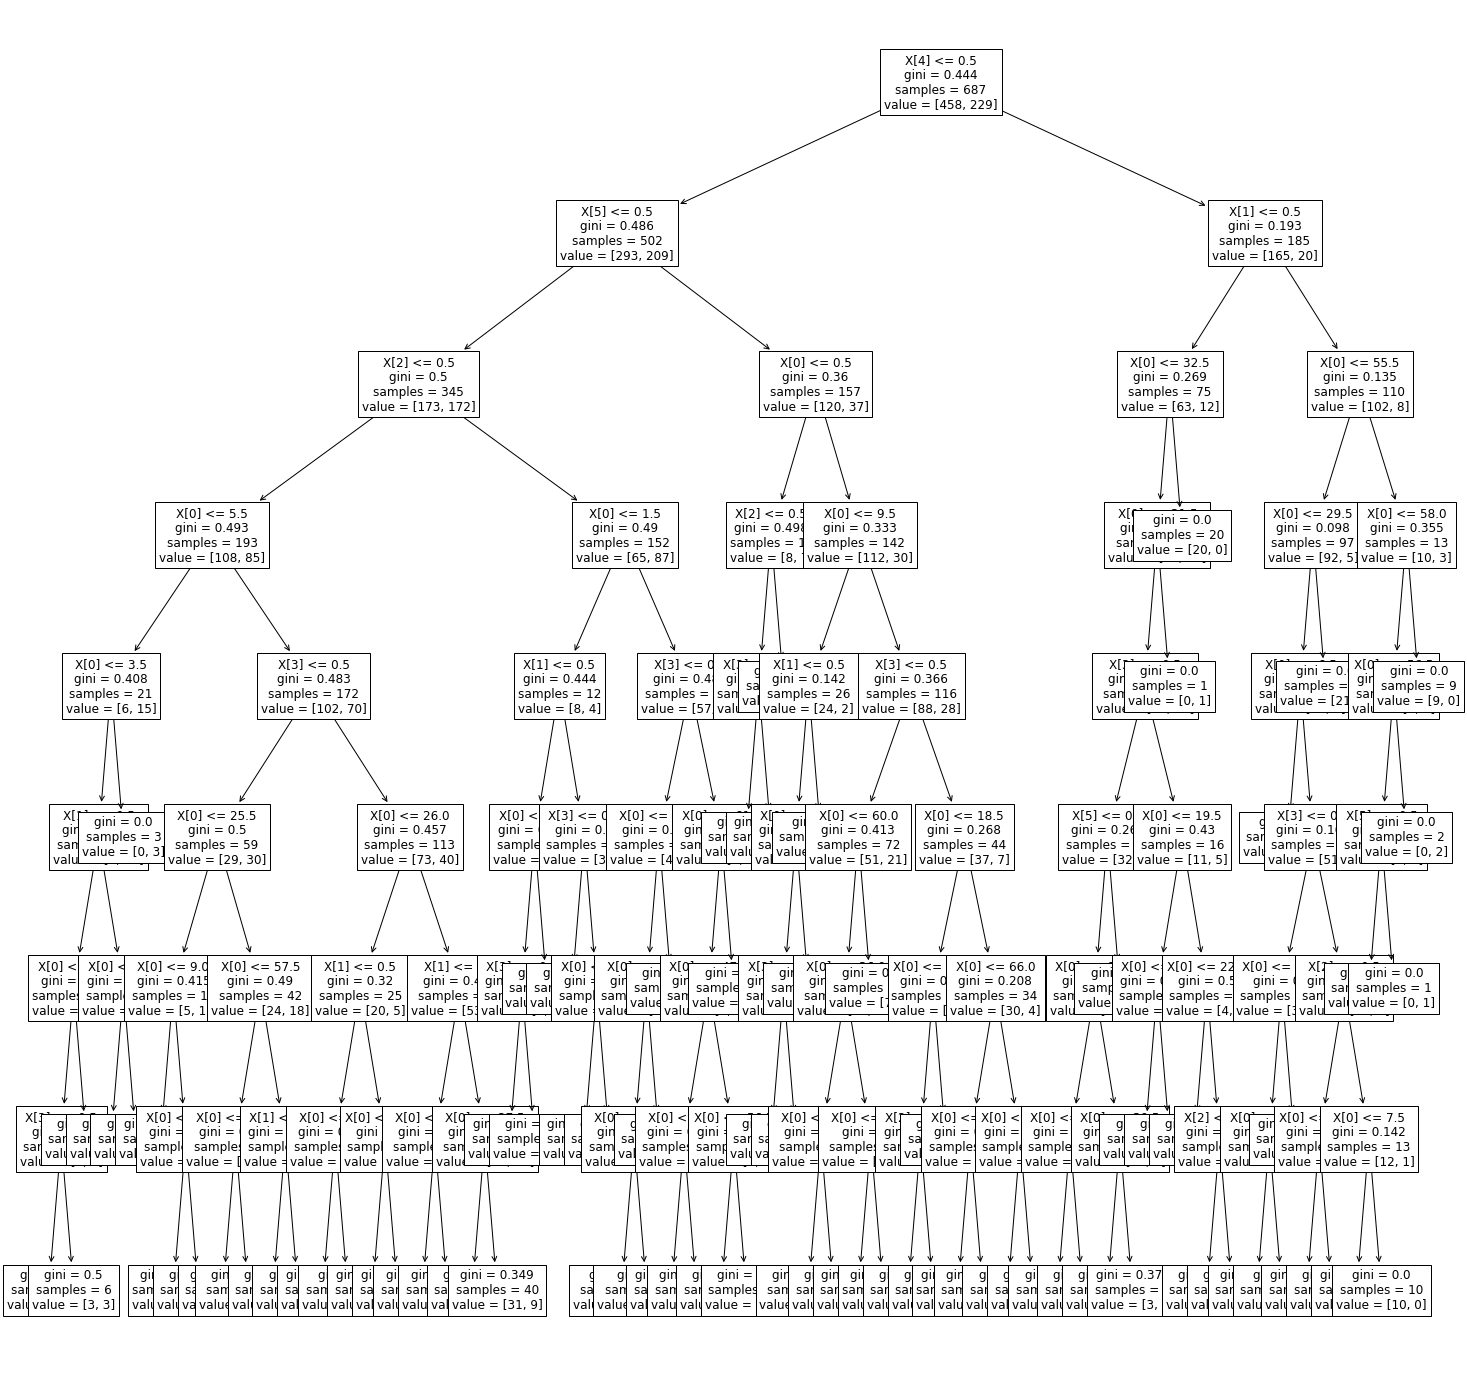

In [34]:
#decision tree visualization 
fig, ax = plt.subplots(figsize=(25, 25))
plot = tree.plot_tree(clf, ax=ax, fontsize=12)

In [35]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[129,  25],
       [ 46,  30]])

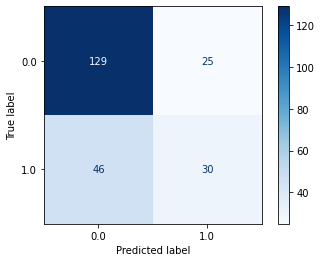

In [36]:

y_pred = clf.predict(x_test)

disp = plot_confusion_matrix(clf, x_test, y_test, cmap=plt.cm.Blues)

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Accuracy = (tp+tn)/(tp+fp+fn+tn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)

print ("Accuracy = ", Accuracy)
print ("Precision = ", Precision)
print("Recall = ", Recall)

Accuracy =  0.691304347826087
Precision =  0.5454545454545454
Recall =  0.39473684210526316
